In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
with open(r'C:\pyproject\archive\games.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

In [4]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

In [5]:
non_game_genres = [
    'software training',
    'design & illustration',
    'web publishing',
    'audio production',
    'animation & modeling',
    'video production',
    'photo editing',
    'game development',
    'movie',
    'utilities'
] #제외시킬 장르

In [6]:
records = []
for app_id, info in data.items():
    try:
        price = info.get('price', 0)
        pos = info.get('positive', 0)
        neg = info.get('negative', 0)
        genres = [g.lower().strip() for g in info.get('genres', [])]  # 소문자 정리 포함 제외
        if (pos + neg) >= 10 and not all(g in non_game_genres for g in genres):
            records.append({
                'name': info.get('name', ''),
                'price': price,
                'positive': pos,
                'negative': neg,
                'total_reviews': pos + neg,
                'positive_ratio': pos / (pos + neg) * 100,
                'genres': genres,
                'release_date': info.get('release_date', '')
            })
    except:
        continue

df = pd.DataFrame(records)
df

,name,price,positive,negative,total_reviews,positive_ratio,genres,release_date
0,Galactic Bowling,19.99,6,11,17,35.294118,"[casual, indie, sports]","Oct 21, 2008"
1,Train Bandit,0.99,53,5,58,91.379310,"[action, indie]","Oct 12, 2017"
2,Two Weeks in Painland,0.00,50,8,58,86.206897,"[adventure, indie]","Feb 3, 2020"
3,Wartune Reborn,0.00,87,49,136,63.970588,"[adventure, casual, free to play, massively mu...","Feb 26, 2021"
4,TD Worlds,10.99,21,7,28,75.000000,"[indie, strategy]","Jan 9, 2022"
...,...,...,...,...,...,...,...,...
46536,Horse Runner DX,4.99,12,1,13,92.307692,"[action, casual, indie]","Mar 6, 2025"
46537,Nautical Survival,6.99,78,0,78,100.000000,"[action, adventure, casual, indie, racing, spo...","Apr 9, 2025"
46538,Pax Augusta,19.99,144,34,178,80.898876,"[simulation, strategy]","Apr 17, 2025"
46539,Mandragora: Whispers of the Witch Tree,39.99,500,234,734,68.119891,"[action, indie, rpg]","Apr 17, 2025"


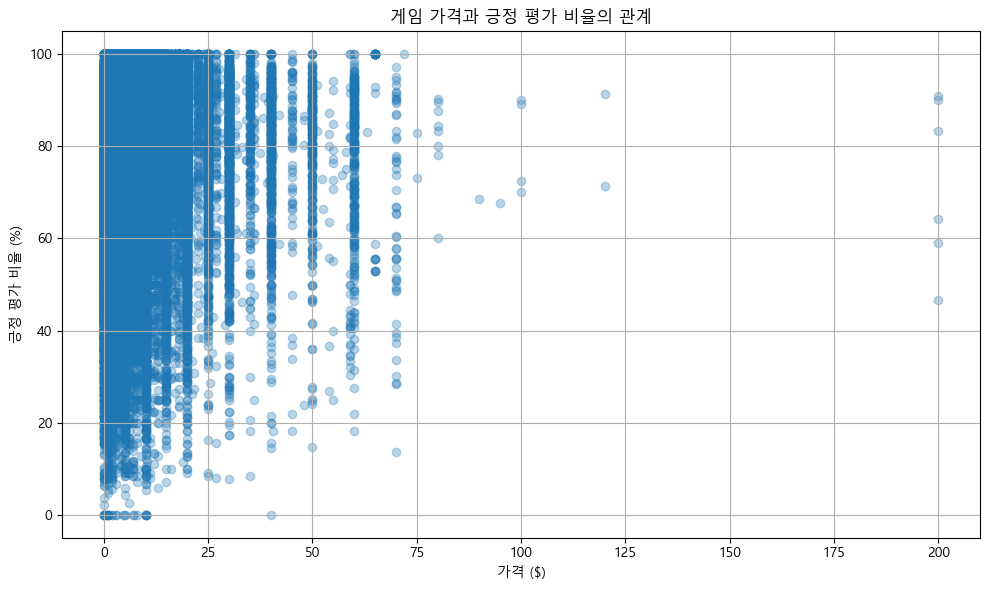

In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(df['price'], df['positive_ratio'], alpha=0.3)
plt.title('게임 가격과 긍정 평가 비율의 관계')
plt.xlabel('가격 ($)')
plt.ylabel('긍정 평가 비율 (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# 가격 구간 설정 및 긍정 비율 평균 계산
bins = list(range(0, int(df['price'].max()) + 10, 10))
labels = [f"${i}-{i+9}" for i in bins[:-1]]
df['price_bin'] = pd.cut(df['price'], bins=bins, labels=labels, right=False)

grouped = df.groupby('price_bin')['positive_ratio'].mean().dropna()

C:\Users\sprs6\AppData\Local\Temp\ipykernel_24672\4074140729.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('price_bin')['positive_ratio'].mean().dropna()


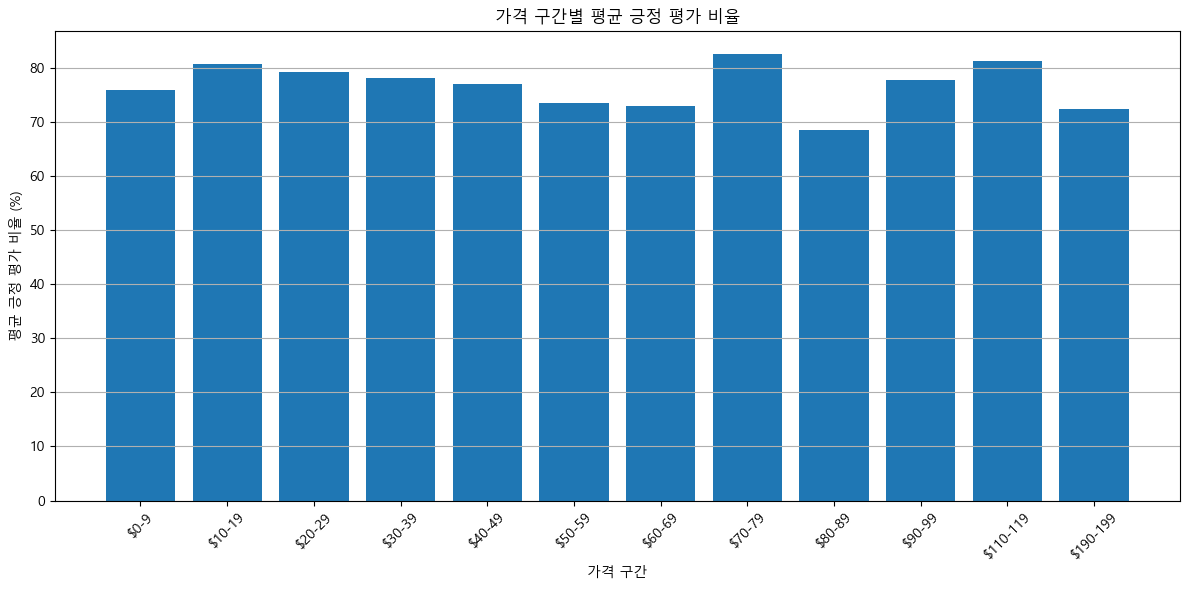

In [9]:
plt.figure(figsize=(12, 6))
plt.bar(grouped.index.tolist(), grouped.values)
plt.xticks(rotation=45)
plt.title('가격 구간별 평균 긍정 평가 비율')
plt.xlabel('가격 구간')
plt.ylabel('평균 긍정 평가 비율 (%)')
plt.tight_layout()
plt.grid(True, axis='y')
plt.show()

In [10]:
# 장르 데이터 분해 및 정제
genre_df = df.copy()
genre_df = genre_df.explode('genres')
genre_df['genres'] = genre_df['genres'].str.lower().str.strip()
genre_df['price'] = pd.to_numeric(genre_df['price'], errors='coerce')
genre_df = genre_df.dropna(subset=['genres', 'price'])

#필요 없는 장르 제거
genre_df = genre_df[~genre_df['genres'].isin(non_game_genres)]

#무료인데 가격이 있는 데이터 제거
genre_df = genre_df[~((genre_df['genres'] == 'free to play') & (genre_df['price'] > 0))]

#장르별 평균 가격 계산
genre_price = genre_df.groupby('genres')['price'].mean().sort_values(ascending=False)

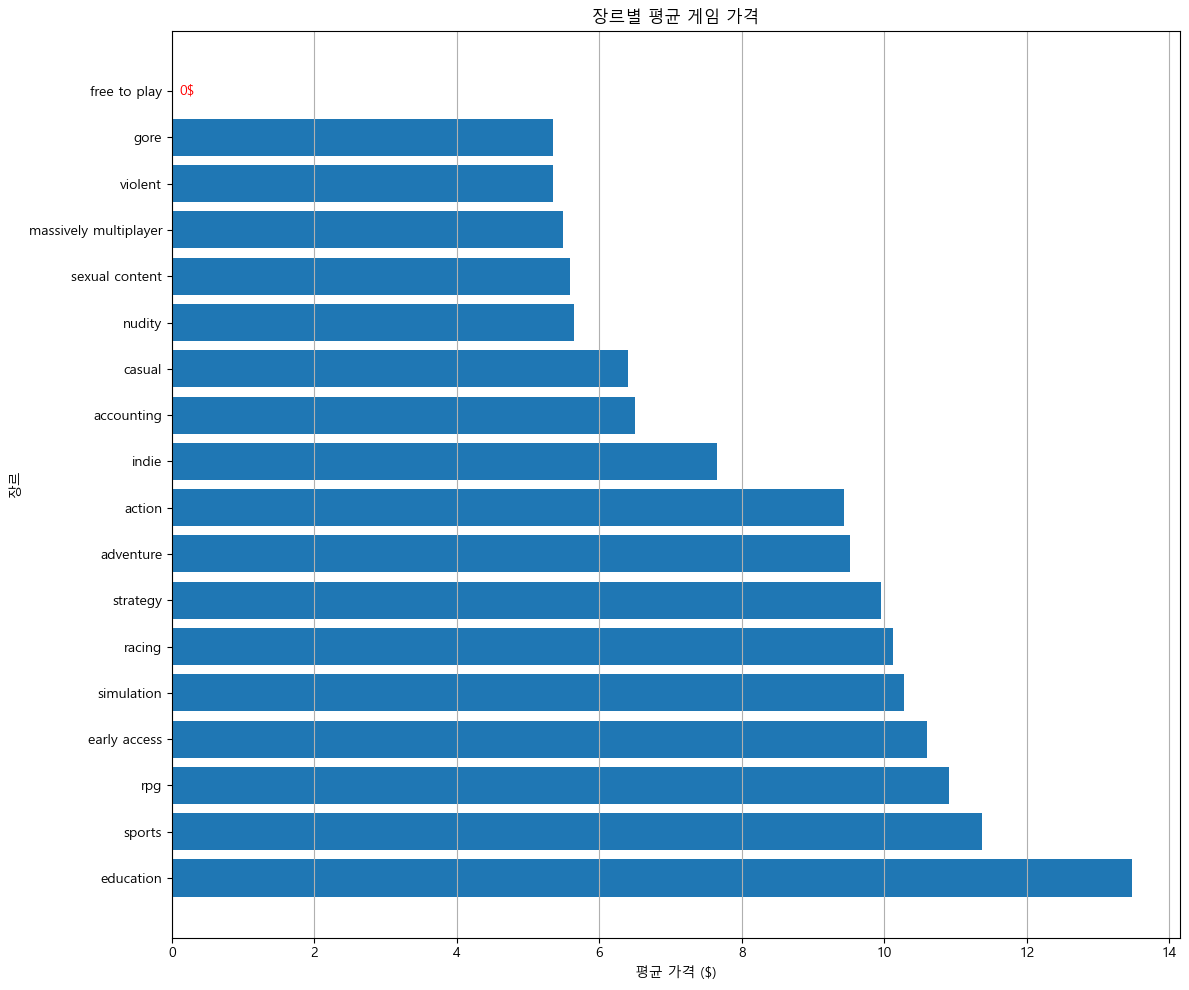

In [11]:
plt.figure(figsize=(12, 10))
plt.barh(genre_price.index, genre_price.values)

# x축 최소값을 0으로 강제 설정 (0 막대 보이도록)
plt.xlim(left=0)

# 값이 0인 항목에도 라벨을 추가 (확인용)
for i, (genre, price) in enumerate(genre_price.items()):
    if price == 0:
        plt.text(0.1, i, '0$', va='center', color='red')  # 0.1 위치에 빨간색으로 표시

plt.title('장르별 평균 게임 가격')
plt.xlabel('평균 가격 ($)')
plt.ylabel('장르')
plt.tight_layout()
plt.grid(True, axis='x')
plt.show()


In [12]:
# 가격 구간 정의
bins = list(range(0, int(genre_df['price'].max()) + 10, 10))
labels = [f"${i}-{i+9}" for i in bins[:-1]]

# 범주형 price_bin 설정
genre_df['price_bin'] = pd.cut(genre_df['price'], bins=bins, labels=labels, right=False)

# 그룹별 긍정률 평균 계산
genre_price_pos = (
    genre_df.groupby(['genres', 'price_bin'], observed=True)['positive_ratio']
    .mean()
    .reset_index()
    .dropna()
)

In [ ]:
# 실제로 사용된 price_bin만 추출
used_labels = genre_price_pos['price_bin'].unique().tolist()
used_labels = [label for label in labels if label in used_labels]  # 순서 유지

# label → 인덱스 매핑
label_order = {v: i for i, v in enumerate(used_labels)}


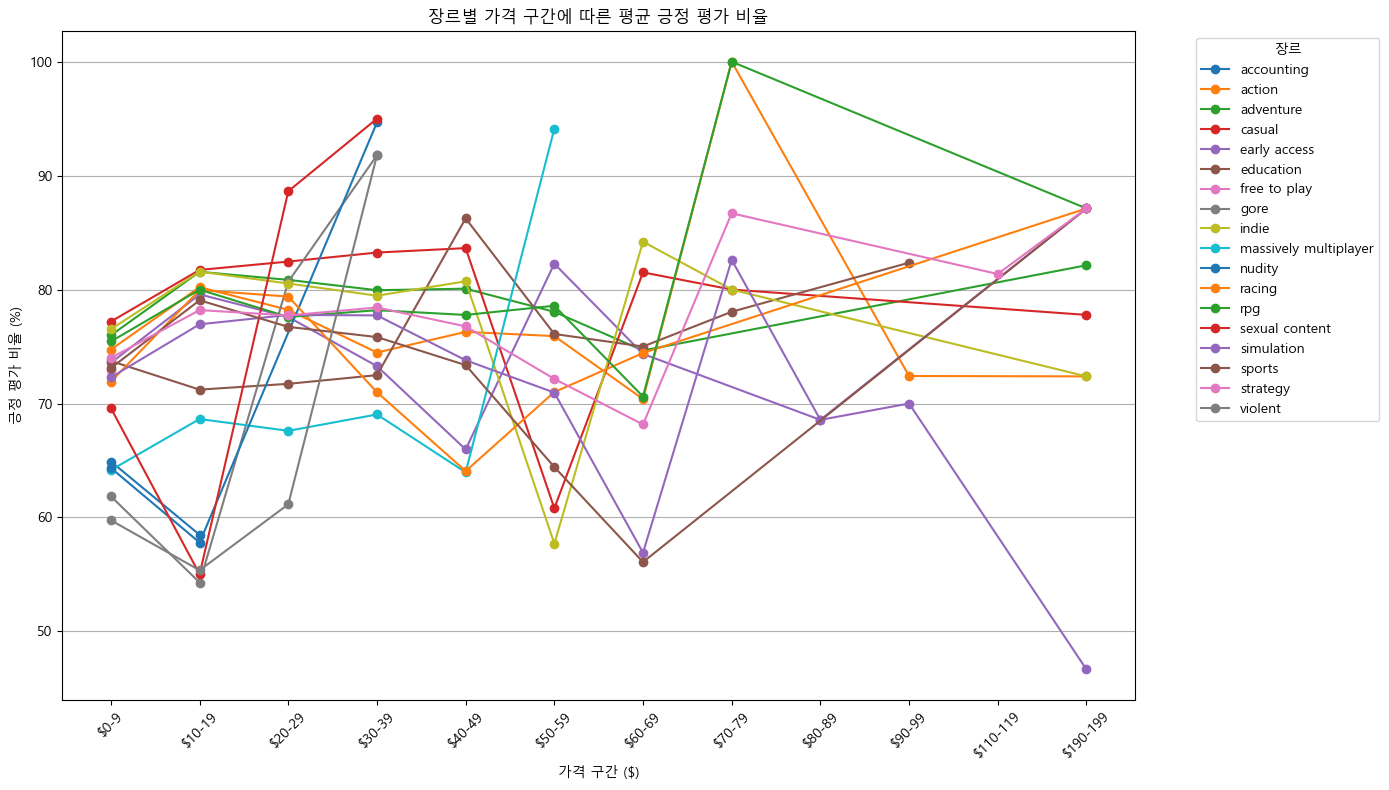

In [14]:
# 시각화: 전체 장르
plt.figure(figsize=(14, 8))

for genre in genre_price_pos['genres'].unique():
    sub = genre_price_pos[genre_price_pos['genres'] == genre].copy()
    sub = sub[sub['price_bin'].isin(used_labels)]  # 필터링
    sub['x'] = sub['price_bin'].map(label_order)
    sub = sub.sort_values(by='x')

    plt.plot(sub['x'], sub['positive_ratio'], marker='o', label=genre)

# x축 설정
plt.xticks(ticks=range(len(used_labels)), labels=used_labels, rotation=45)
plt.title('장르별 가격 구간에 따른 평균 긍정 평가 비율')
plt.xlabel('가격 구간 ($)')
plt.ylabel('긍정 평가 비율 (%)')
plt.legend(title='장르', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True, axis='y')
plt.show()

In [24]:
# 상위 N개 장르 추출
top_genres = genre_price_pos['genres'].value_counts().head(5).index
top_df = genre_price_pos[genre_price_pos['genres'].isin(top_genres)].copy()

# ✅ 실제 사용된 price_bin만 추출
used_labels = genre_price_pos['price_bin'].unique().tolist()
used_labels = [label for label in labels if label in used_labels]
label_order = {v: i for i, v in enumerate(used_labels)}

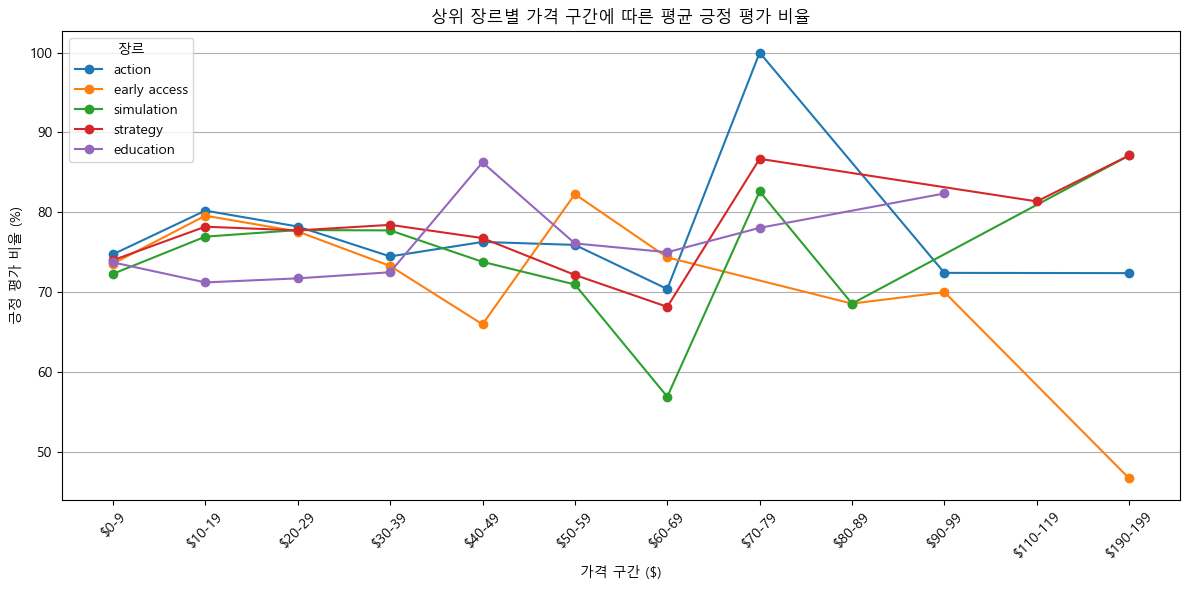

In [ ]:
# 시각화
plt.figure(figsize=(12, 6))
for genre in top_genres:
    sub = top_df[top_df['genres'] == genre].copy()
    sub = sub[sub['price_bin'].isin(used_labels)]
    sub['x'] = sub['price_bin'].map(label_order)
    sub = sub.sort_values(by='x')

    plt.plot(sub['x'], sub['positive_ratio'], marker='o', label=genre)

plt.xticks(ticks=range(len(used_labels)), labels=used_labels, rotation=45)
plt.title('상위 장르별 가격 구간에 따른 평균 긍정 평가 비율')
plt.xlabel('가격 구간 ($)')
plt.ylabel('긍정 평가 비율 (%)')
plt.legend(title='장르')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

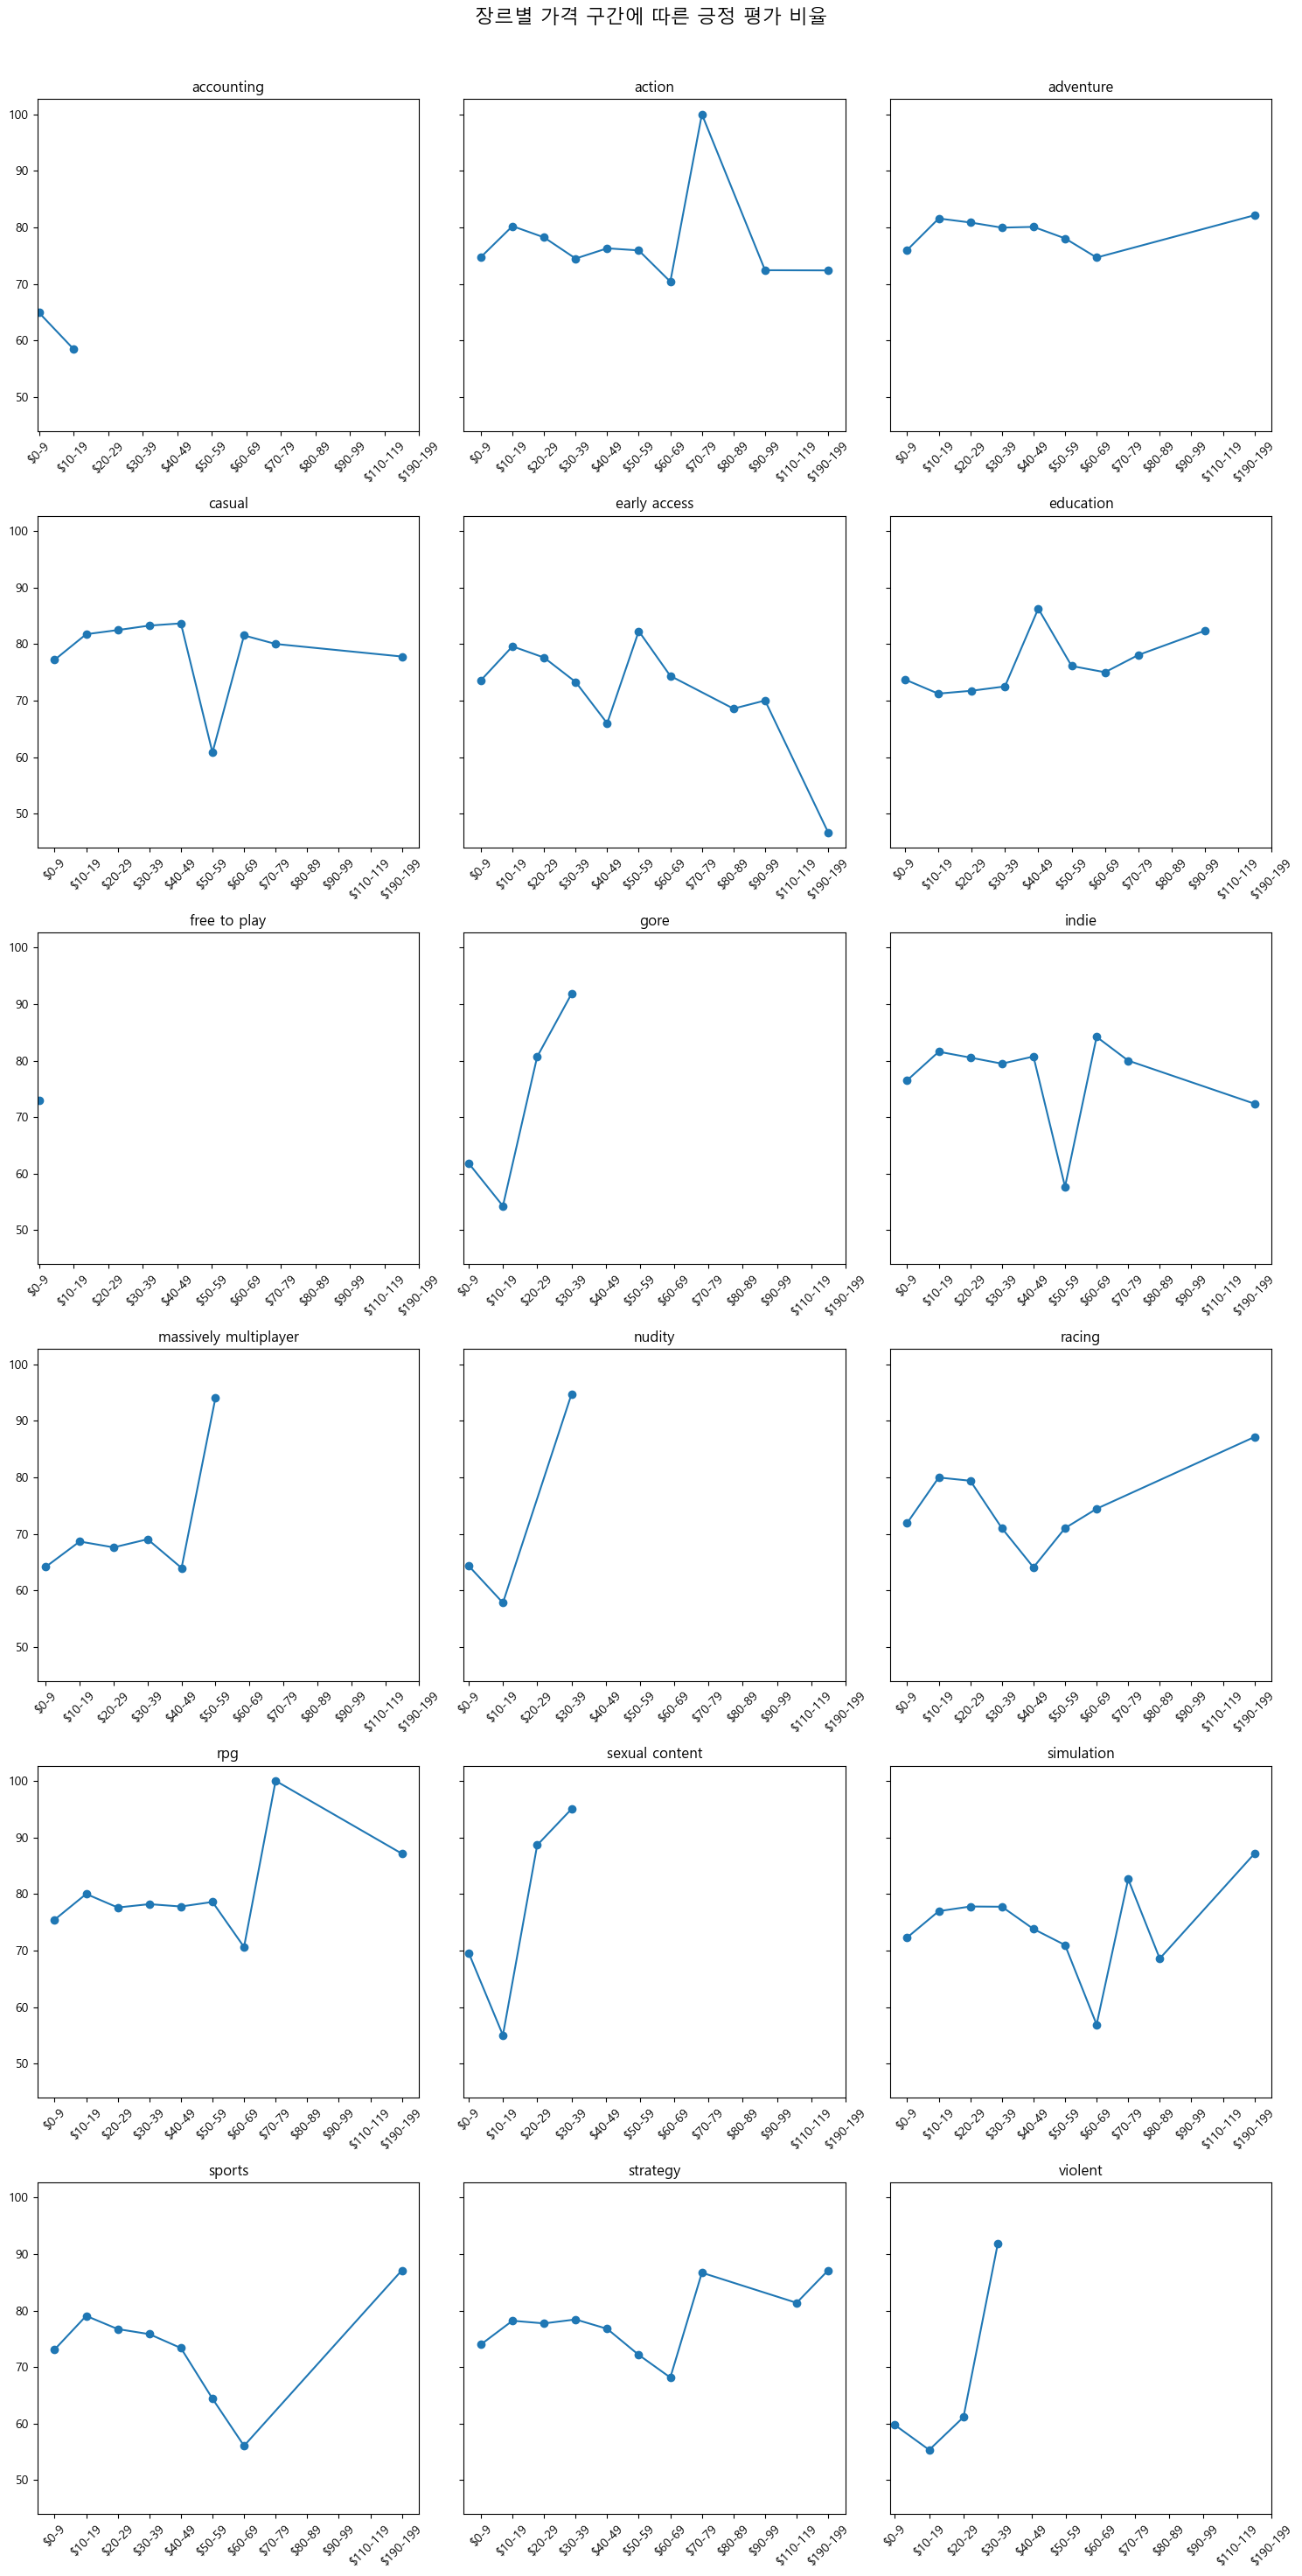

In [27]:
# 실제 사용된 price_bin만 추출하고 순서 정의
used_labels = genre_price_pos['price_bin'].unique().tolist()
used_labels = [label for label in labels if label in used_labels]
label_order = {v: i for i, v in enumerate(used_labels)}

# 필요한 장르 수
unique_genres = genre_price_pos['genres'].unique()
num_genres = len(unique_genres)

# subplot 그리드 크기 계산
cols = 3
rows = (num_genres + cols - 1) // cols

fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows), sharex=False, sharey=True)
axs = axs.flatten()

for i, genre in enumerate(unique_genres):
    sub = genre_price_pos[genre_price_pos['genres'] == genre].copy()
    sub = sub[sub['price_bin'].isin(used_labels)]
    sub['x'] = sub['price_bin'].map(label_order)
    sub = sub.sort_values(by='x')

    axs[i].plot(sub['x'], sub['positive_ratio'], marker='o')
    axs[i].set_title(genre)
    axs[i].set_xticks(range(len(used_labels)))
    axs[i].set_xticklabels(used_labels, rotation=45)

# 빈 subplot 제거
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

fig.suptitle('장르별 가격 구간에 따른 긍정 평가 비율', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In [17]:
# 날짜에서 연도만 추출
df['year'] = pd.to_datetime(df['release_date'], errors='coerce').dt.year

# 유효한 연도만 필터링
df = df[df['year'].notna() & (df['year'] >= 2000) & (df['year'] <= 2025)]
df['year'] = df['year'].astype(int)

# 연도별 게임 수 계산
year_counts = df['year'].value_counts()

# 게임 수가 10개 이상인 연도만 선택
valid_years = year_counts[year_counts >= 10].index

# 연도 필터 적용
filtered_df = df[df['year'].isin(valid_years)]

# 연도별 평균 가격 계산
yearly_price = filtered_df.groupby('year')['price'].mean()

C:\Users\sprs6\AppData\Local\Temp\ipykernel_24672\3317027380.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['year'].astype(int)


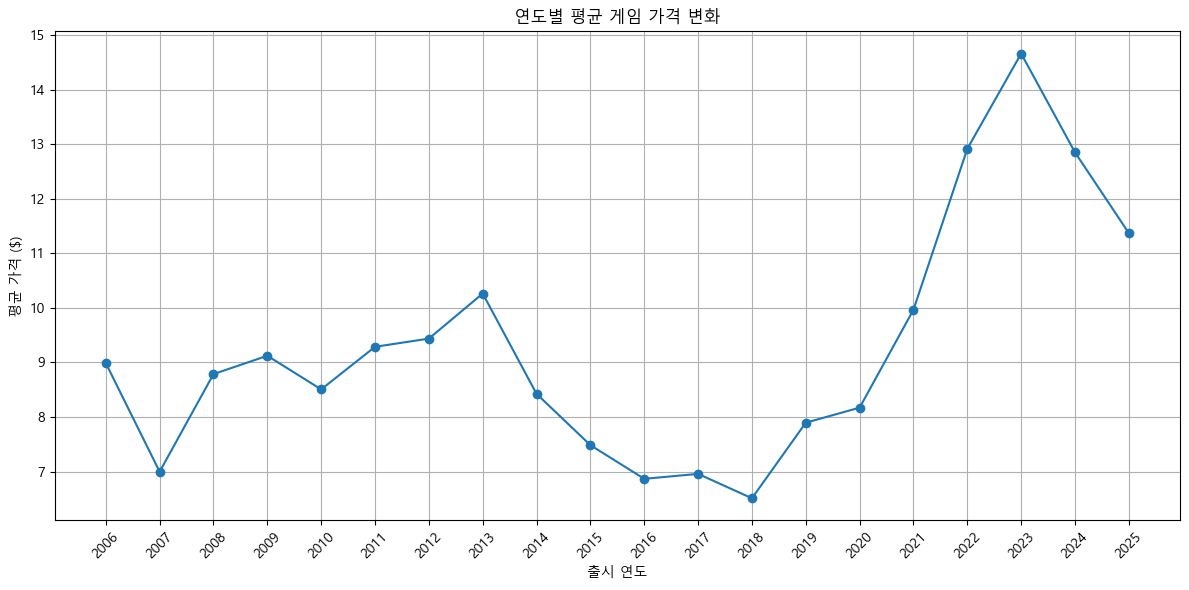

In [ ]:
# 시각화
plt.figure(figsize=(12, 6))
plt.plot(yearly_price.index, yearly_price.values, marker='o')
plt.title('연도별 평균 게임 가격 변화')
plt.xlabel('출시 연도')
plt.ylabel('평균 가격 ($)')
plt.grid(True)
plt.xticks(ticks=yearly_price.index, labels=yearly_price.index.astype(str), rotation=45)
plt.tight_layout()
plt.show()

In [29]:
# 장르 데이터 복사 및 연도 병합
genre_year_df = df[['year', 'price', 'genres']].explode('genres').dropna()
genre_year_df['genres'] = genre_year_df['genres'].str.lower().str.strip()

# 'free to play'이면서 가격이 0이 아닌 경우 필터링
genre_year_df = genre_year_df[~((genre_year_df['genres'] == 'free to play') & (genre_year_df['price'] > 0))]

# 비게임 장르
genre_year_df = genre_year_df[~genre_year_df['genres'].isin(non_game_genres)]

# 장르 x 연도별 게임 수 계산
genre_year_counts = genre_year_df.groupby(['genres', 'year']).size().reset_index(name='count')

# 게임 수 10개 이상인 조합만 필터링
valid_combinations = genre_year_counts[genre_year_counts['count'] >= 10][['genres', 'year']]
genre_year_df = genre_year_df.merge(valid_combinations, on=['genres', 'year'], how='inner')

# 평균 가격 재계산
genre_year_price = (
    genre_year_df.groupby(['genres', 'year'])['price']
    .mean()
    .reset_index()
)

# 인기 장르 추출
top_genres = genre_year_df['genres'].value_counts().head(5).index
filtered = genre_year_price[genre_year_price['genres'].isin(top_genres)]


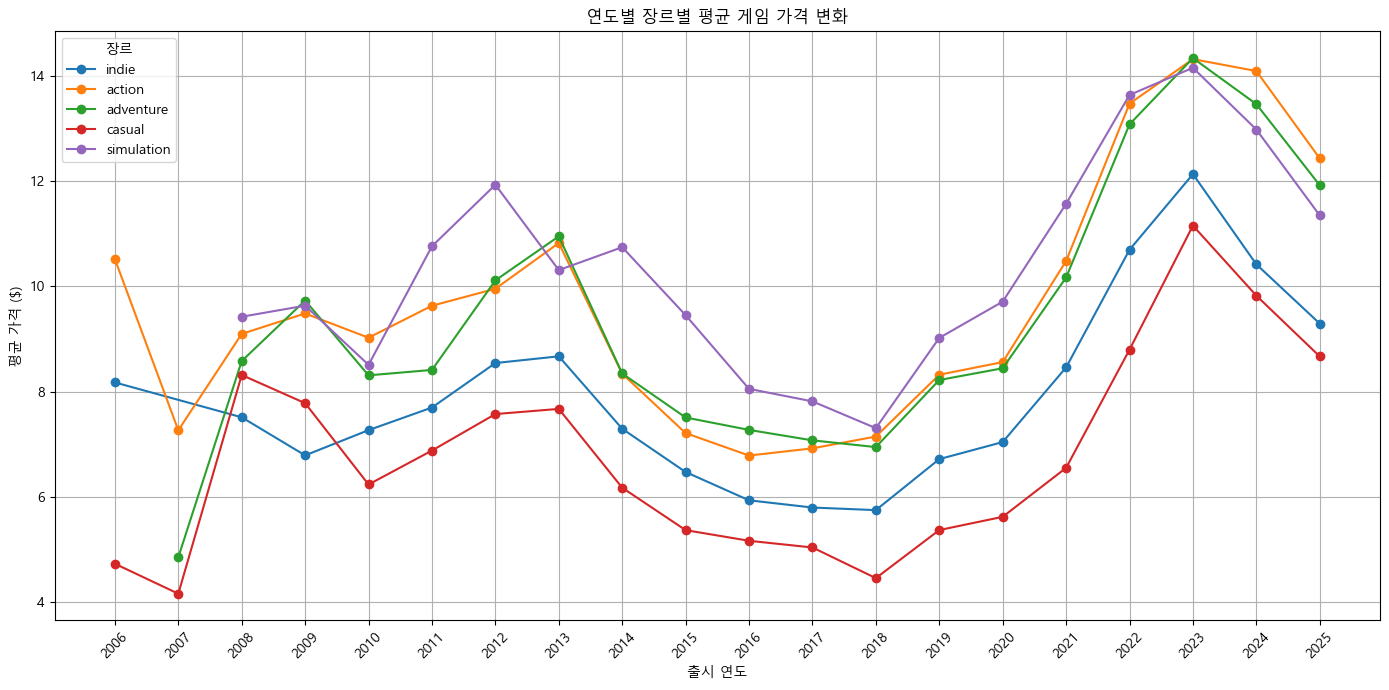

In [30]:
# 시각화
plt.figure(figsize=(14, 7))
for genre in top_genres:
    sub = filtered[filtered['genres'] == genre]
    plt.plot(sub['year'], sub['price'], marker='o', label=genre)

plt.title('연도별 장르별 평균 게임 가격 변화')
plt.xlabel('출시 연도')
plt.ylabel('평균 가격 ($)')
plt.legend(title='장르')
plt.grid(True)
plt.xticks(ticks=yearly_price.index, labels=yearly_price.index.astype(str), rotation=45)
plt.tight_layout()
plt.show()


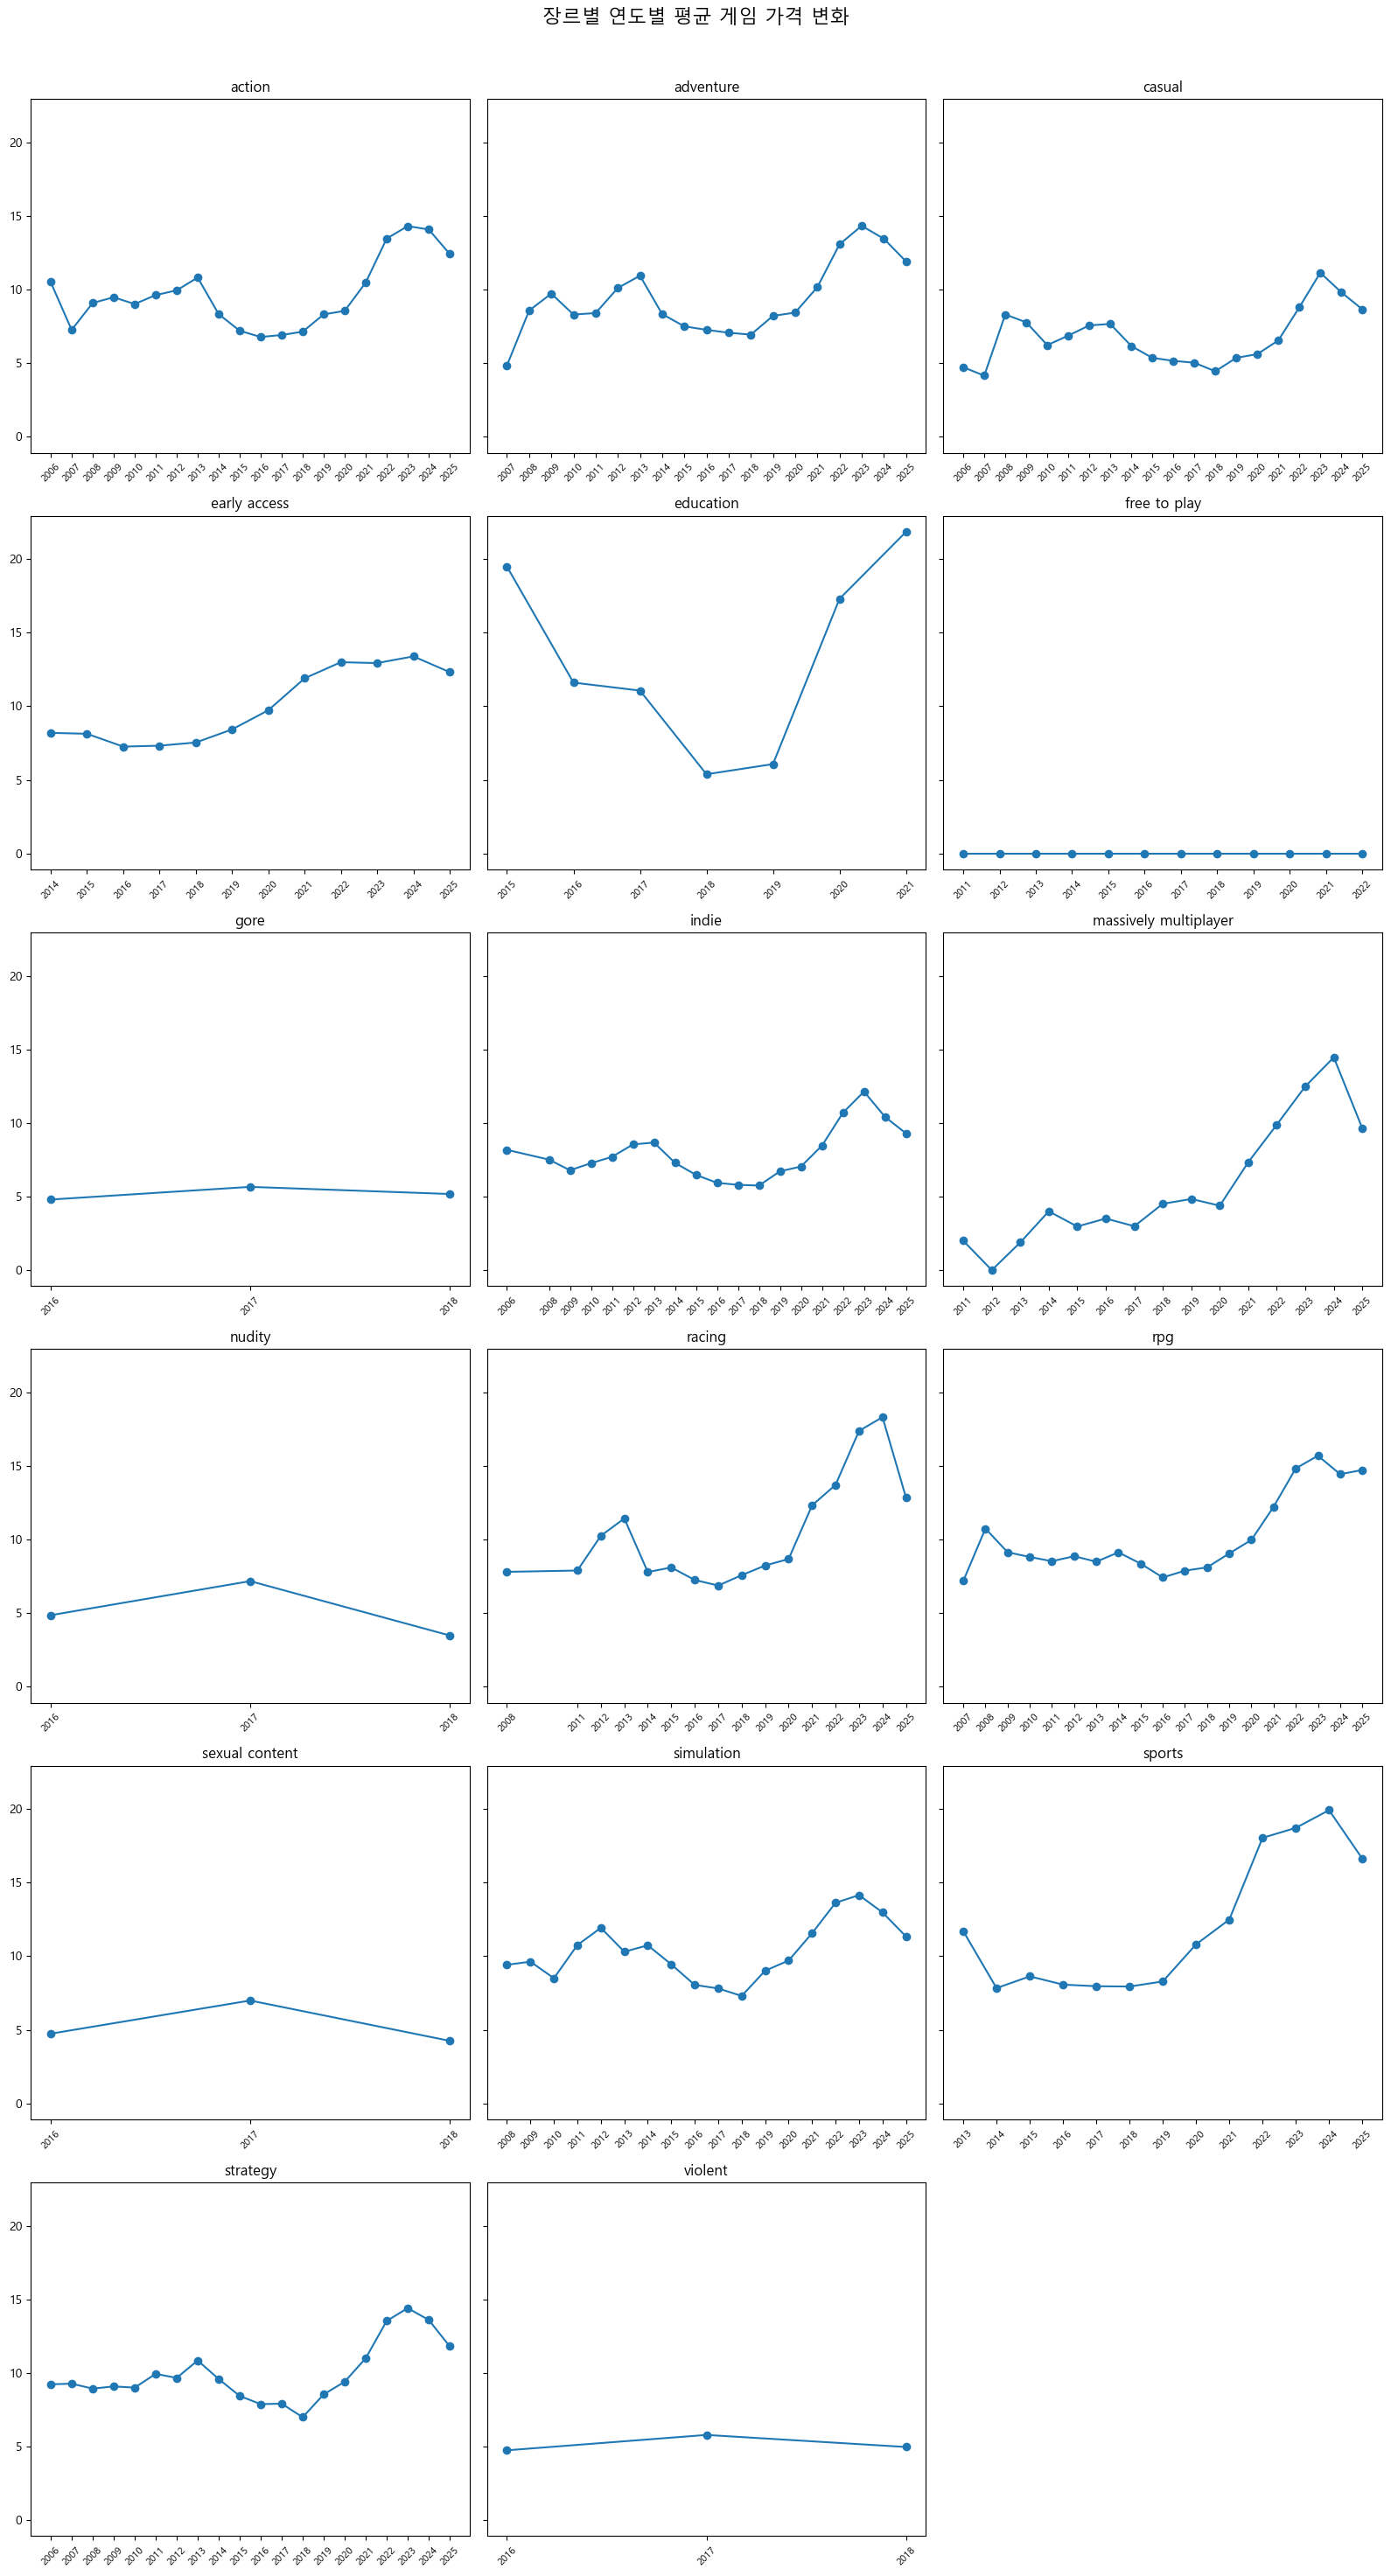

In [31]:
# 필요한 장르 목록
unique_genres = genre_year_price['genres'].unique()
num_genres = len(unique_genres)

# subplot 그리드 크기 계산
cols = 3
rows = (num_genres + cols - 1) // cols

# 각 subplot마다 독립된 x축 사용
fig, axs = plt.subplots(rows, cols, figsize=(16, 5 * rows), sharex=False, sharey=True)
axs = axs.flatten()

for i, genre in enumerate(unique_genres):
    sub = genre_year_price[genre_year_price['genres'] == genre]
    years = sub['year'].astype(int)
    prices = sub['price']

    axs[i].plot(years, prices, marker='o')
    axs[i].set_title(genre)

    # 연도 눈금 전부 표시 + 회전 + 글씨 크기
    axs[i].set_xticks(years)
    axs[i].set_xticklabels(years.astype(str), rotation=45)
    axs[i].tick_params(axis='x', labelsize=8)

# 빈 그래프 제거
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

fig.suptitle('장르별 연도별 평균 게임 가격 변화', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
